# Fine-Tuning BERT on Quora Question pairs

# Introduction

In this project, we would use a variety of BERT models (BERT, RoBERTa, ALBERT, DistilBERT, DeBERTa) with the HuggingFace PyTorch library to fine-tune a model to fit the QQP dataset. 

### BERT (Bidirectional Encoder Representations from Transformers) 

Original model code [here](https://github.com/google-research/bert) for NLP tasks.

BERT consists of 12 Transformer Encoding layers (or 24 for large BERT)


# Quora Question Pairs Dataset
[Quora](https://www.quora.com/) is a question-and-answer website where questions are asked, answered, followed, and edited by Internet users, either factually or in the form of opinions. Quora was co-founded by former Facebook employees Adam D'Angelo and Charlie Cheever in June 2009. website was made available to the public for the first time on June 21, 2010. Today the website is available in many languages.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question.

The goal is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The dataset itself can be downloaded from kaggle: [here](https://www.kaggle.com/c/quora-question-pairs/).

## Data fields
* id - the id of a training set question pair
* qid1, qid2 - unique ids of each question (only available in train.csv)
* question1, question2 - the full text of each question
* is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

To make use of GPU, this notebook should be run on Google Colab or Kaggle. It is highly inadvisable to run this notebook on a local machine as it would take a very long time to train the model. However you can run on local for testing purposes.

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test.tsv
/kaggle/input/quora_duplicate_questions.tsv
/kaggle/input/dev.tsv
/kaggle/input/train.tsv


In [2]:
### Importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset

#### Due to memory and time limit issues, we cannot really use the whole dataset for fine tuning. As a result, we would use a subset of the dataset for training and validation.

In [3]:
num_train_plus_test = 20000 # Later, train and test data ratio is 80:20
num_val = 2000 
num_unknown_labels_test = 5000
# If you want to use all data, set values to None

In [4]:
# train_qqp = pd.read_csv("/kaggle/input/snlp-project-qqp/train.tsv", sep="\t")
# dev_qqp = pd.read_csv("/kaggle/input/snlp-project-qqp/dev.tsv", sep="\t")

train_qqp = pd.read_csv("/kaggle/input/train.tsv", sep="\t", nrows=num_train_plus_test)
dev_qqp = pd.read_csv("/kaggle/input/dev.tsv", sep="\t", nrows=num_val)

test_unknown_label_qqp = pd.read_csv("/kaggle/input/test.tsv", sep="\t", nrows=num_unknown_labels_test)
print(len(test_unknown_label_qqp))
train_qqp.head()

5000


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,402555,536040,536041,How do I control my horny emotions?,How do you control your horniness?,1
2,360472,364011,490273,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,150662,155721,7256,What can one do after MBBS?,What do i do after my MBBS ?,1
4,183004,279958,279959,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


## BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

We’ll be using [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

### Choosing the BERT variant and the Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. The tokenization must be performed by the tokenizer included with BERT. This Tokenizer is build upon the WordPiece tokenizer. 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The current device is", device)

The current device is cuda


In [6]:
# PLEASE CHOOSE THE BERT VARIANT MODEL

# bert_model_name = "bert-base-uncased"
bert_model_name = "roberta-base"
# bert_model_name = "distilbert-base-uncased"
# bert_model_name = "albert-base-v2"
# bert_model_name = "deberta-base"

from transformers import AutoTokenizer, AutoModelForSequenceClassification

bert_temp_name = "microsoft/deberta-base" if bert_model_name == "deberta-base" else bert_model_name

tokenizer = AutoTokenizer.from_pretrained(bert_temp_name)
bert_classification_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=bert_temp_name,
    num_labels=2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
)

bert_classification_model = bert_classification_model.to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenizing
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. 

In [7]:
example_question = train_qqp['question1'][0]

print(f"Original sentence:\n {example_question}")

example_tokens = tokenizer.tokenize(example_question)

print(f"\nTokenized by {bert_model_name}:\n {example_tokens}")

example_tokens_ID = tokenizer.convert_tokens_to_ids(example_tokens)
print(f"\nToken IDs by {bert_model_name}:\n {example_tokens_ID}")

Original sentence:
 How is the life of a math student? Could you describe your own experiences?

Tokenized by roberta-base:
 ['How', 'Ġis', 'Ġthe', 'Ġlife', 'Ġof', 'Ġa', 'Ġmath', 'Ġstudent', '?', 'ĠCould', 'Ġyou', 'Ġdescribe', 'Ġyour', 'Ġown', 'Ġexperiences', '?']

Token IDs by roberta-base:
 [6179, 16, 5, 301, 9, 10, 10638, 1294, 116, 9918, 47, 6190, 110, 308, 3734, 116]


We can combine ``tokenize`` and ``convert_tokens_to_ids`` with the method ``encode``:

In [8]:
example_question = train_qqp['question1'][0]

print(f"Original sentence:\n {example_question}")

example_tokens_ID = tokenizer.encode(example_question)

print(f"\nToken IDs by {bert_model_name}:\n {example_tokens_ID}")

Original sentence:
 How is the life of a math student? Could you describe your own experiences?

Token IDs by roberta-base:
 [0, 6179, 16, 5, 301, 9, 10, 10638, 1294, 116, 9918, 47, 6190, 110, 308, 3734, 116, 2]


We can see we got two extra tokens at the start and at the end compared to previous versions. Let's see what they are:

In [9]:
tokenizer.decode(example_tokens_ID)

2024-04-17 06:59:51.992356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 06:59:51.992484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 06:59:52.141377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'<s>How is the life of a math student? Could you describe your own experiences?</s>'

## Special Tokens
``[SEP]`` - At the end of every sentence, we need to append the special ``[SEP]`` token.

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (remeber BERT was trained intially to perdict question-answering task).

``[CLS]`` - For classification tasks, we must prepend the special ``[CLS]`` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

So now let's see how to encode the two questions together:

In [10]:
example_question_1 = train_qqp['question1'][0]
example_question_2 = train_qqp['question2'][0]

encoded_pair = tokenizer.encode(example_question_1, example_question_2)
tokenizer.decode(encoded_pair)

'<s>How is the life of a math student? Could you describe your own experiences?</s></s>Which level of prepration is enough for the exam jlpt5?</s>'

## Sentence Length

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.
Padding is done with a special ``[PAD]`` token, which is at index 0 in the BERT vocabulary.

The maximum length does impact training and evaluation speed.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

Let's find the maximum length:

In [11]:
tqdm.pandas()
train_qqp["question1_length"] = train_qqp["question1"].progress_apply(lambda question: 
                                                        len(tokenizer.tokenize(question)))
train_qqp["question2_length"] = train_qqp["question2"].progress_apply(lambda question: 
                                                        len(tokenizer.tokenize(question)))
train_qqp["joint_length"] = train_qqp["question1_length"] + train_qqp["question2_length"]

MAX_LENGTH = train_qqp["joint_length"].max()

print("The maximum sentence length is ", MAX_LENGTH)

100%|██████████| 20000/20000 [00:01<00:00, 10141.71it/s]

The maximum sentence length is  297


### Now we construct the training, validation, testing dataset with known labels and testing dataset with unknown labels

In [12]:
X_train, X_test_known_labels, y_train, y_test_known_labels = train_test_split(train_qqp[["question1", "question2"]], 
                                                    train_qqp["is_duplicate"], test_size=0.2, random_state=42)
X_val = dev_qqp[["question1", "question2"]]
y_val = dev_qqp["is_duplicate"]

X_test_unknown_labels = test_unknown_label_qqp[["question1", "question2"]]

# Tokenize dataset and create Dataloader

Now we’re ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special ``[CLS]`` and ``[SEP]`` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from ``[PAD]`` tokens.

Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).

In [13]:
MAX_LENGTH = 327

tokenizer.encode_plus(X_train.iloc[0]["question1"], 
                      X_train.iloc[0]["question2"], 
                      max_length=MAX_LENGTH, 
                      padding='max_length', 
                      return_attention_mask=True, 
                      return_tensors='pt', 
                      truncation=True)

{'input_ids': tensor([[    0,  1106, 17923,    56,  3360,     9,  2668,    18, 11809,    99,
            74,    37,   109,   116,     2,     2,  6179,    16,   295,   324,
           438,   364,  1755,   132,  1187,  3294,   116,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

So what we got:

1. input_ids - Token ids padded with 0 at the end.
2. token_type_ids - This array indicates bert what is the first sentence and what is the seconds. In case of classification of only one sentance this array is redundant.
3. attention_mask - The “Attention Mask” is simply an array of 1s and 0s indicating which tokens are padding and which aren’t. This mask tells the “Self-Attention” mechanism in BERT not to incorporate these ``[PAD]`` tokens into its interpretation of the sentence.

All the array are in the size of ``max_length``.

In [14]:
def convert_to_dataset_torch(features, labels):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for _, row in tqdm(features.iterrows(), total=features.shape[0]):
        encoded_dict = tokenizer.encode_plus(row["question1"], 
                                             row["question2"], 
                                             padding='max_length', 
                                             return_attention_mask=True, 
                                             return_tensors='pt', 
                                             truncation=True)
        # print(encoded_dict.keys())
        
        # Add the encoded sentences to the list.
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
        if bert_model_name in ["bert-base-uncased", "albert-base-v2", "deberta-base"]:
            token_type_ids.append(encoded_dict["token_type_ids"])
        
    # Convert the lists into tensors.
    if bert_model_name in ["bert-base-uncased", "albert-base-v2", "deberta-base"]:

        input_ids = torch.cat(input_ids, dim=0)
        token_type_ids = torch.cat(token_type_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels.values)
        
        print("Shape of input_ids is", input_ids.shape)
        print("Shape of token_type_ids is", token_type_ids.shape)
        print("Shape of attention_masks is", attention_masks.shape)
        print("Shape of labels is", labels.shape)
        
        return TensorDataset(input_ids, attention_masks, token_type_ids, labels)
    
    elif bert_model_name in ["roberta-base", "distilbert-base-uncased"]:
        # roberta does not have token_type_ids
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels.values)
        
        print("Shape of input_ids is", input_ids.shape)
        print("Shape of attention_masks is", attention_masks.shape)
        print("Shape of labels is", labels.shape)
        
        return TensorDataset(input_ids, attention_masks, labels)
    

We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory:

In [15]:
train_tensor = convert_to_dataset_torch(X_train, y_train)

100%|██████████| 16000/16000 [00:13<00:00, 1224.77it/s]


Shape of input_ids is torch.Size([16000, 512])
Shape of attention_masks is torch.Size([16000, 512])
Shape of labels is torch.Size([16000])


In [16]:
val_tensor = convert_to_dataset_torch(X_val, y_val)

100%|██████████| 2000/2000 [00:01<00:00, 1303.91it/s]


Shape of input_ids is torch.Size([2000, 512])
Shape of attention_masks is torch.Size([2000, 512])
Shape of labels is torch.Size([2000])


In [17]:
import multiprocessing

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.

batch_size = 5

core_number = multiprocessing.cpu_count()

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_tensor,  # The training samples.
            sampler = RandomSampler(train_tensor), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers = core_number
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
            val_tensor, # The validation samples.
            sampler = SequentialSampler(val_tensor), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            num_workers = core_number
        )

# Training Loop
Helper function for formatting elapsed times as ``hh:mm:ss``:

In [18]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### This function trains the batches from the train_dataloader

In [19]:
def train_batch(epoch, bert_classification_model, train_dataloader, optimizer, scheduler, metric):
    
    total_train_loss = 0
    total_train_accuracy = 0
    
    for batch in tqdm(train_dataloader, desc=f"Training epoch: {epoch}", unit="batch"):
        
        if bert_model_name in ["bert-base-uncased", "albert-base-v2", "deberta-base"]:

            # Unpack batch from dataloader.
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            token_type_ids = batch[2].to(device)
            labels = batch[3].to(device)
            
            bert_classification_model.zero_grad()
            
            # Forward pass
            outputs = bert_classification_model(input_ids, 
                                token_type_ids=token_type_ids, 
                                attention_mask=attention_masks, 
                                labels=labels)
            
        elif bert_model_name in ["roberta-base", "distilbert-base-uncased"]:
            # Unpack batch from dataloader.
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)
            
            bert_classification_model.zero_grad()
            
            # Forward pass
            outputs = bert_classification_model(input_ids, 
                                attention_mask=attention_masks, 
                                labels=labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bert_classification_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        y_pred = np.argmax(logits.cpu().detach().numpy(), axis=1).flatten()
        
        total_train_accuracy += metric(labels.cpu(), y_pred)

    return total_train_loss, total_train_accuracy

### This function validates the batches from the val_dataloader

In [20]:
def val_batch(epoch, bert_classification_model, val_dataloader, metric):
    total_val_loss = 0
    total_val_accuracy = 0
    predicted_logits , predicted_labels = [], []
    
    for batch in tqdm(val_dataloader, desc=f"Validating epoch: {epoch}", unit="batch"):
        # Unpack batch from dataloader.
        
        if bert_model_name in ["bert-base-uncased", "albert-base-v2", "deberta-base"]:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            token_type_ids = batch[2].to(device)
            labels = batch[3].to(device)

            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                outputs = bert_classification_model(input_ids, 
                                    token_type_ids=token_type_ids, 
                                    attention_mask=attention_masks,
                                    labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                
        elif bert_model_name in ["roberta-base", "distilbert-base-uncased"]:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)

            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                outputs = bert_classification_model(input_ids, 
                                    attention_mask=attention_masks,
                                    labels=labels)
                loss = outputs.loss
                logits = outputs.logits
            
        total_val_loss += loss.item()
        
        y_pred = np.argmax(logits.cpu().detach().numpy(), axis=1).flatten()
        
        total_val_accuracy += metric(labels.cpu(), y_pred)
        
        predicted_logits.extend(logits.cpu().detach().numpy().tolist())
        predicted_labels.extend(y_pred.tolist())
    
    return total_val_loss, total_val_accuracy, predicted_logits, predicted_labels

### This function predicts the classes of the batches from the test_dataloader. Now the test_dataloader only contains X_test without y_test (which is None)

In [21]:
def predict_batch(bert_classification_model, predict_dataloader):
    
    predicted_logits , predicted_labels = [], []
    
    for batch in tqdm(predict_dataloader, desc=f"Predicting", unit="batch"):
        # Unpack batch from dataloader.
        
        if bert_model_name in ["bert-base-uncased", "albert-base-v2", "deberta-base"]:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            token_type_ids = batch[2].to(device)

            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                outputs = bert_classification_model(input_ids, 
                                    token_type_ids=token_type_ids, 
                                    attention_mask=attention_masks)
                logits = outputs.logits
                
        elif bert_model_name in ["roberta-base", "distilbert-base-uncased"]:
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)

            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                outputs = bert_classification_model(input_ids, 
                                    attention_mask=attention_masks)
                logits = outputs.logits
            
        y_pred = np.argmax(logits.cpu().detach().numpy(), axis=1).flatten()
                
        predicted_logits.extend(logits.cpu().detach().numpy().tolist())
        predicted_labels.extend(y_pred.tolist())
    
    return predicted_logits, predicted_labels

In [22]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

def fine_tuning_pretrained_model(epochs, bert_classification_model, 
                                 train_dataloader, 
                                 val_dataloader, 
                                 optimizer, 
                                 scheduler,
                                 metric
                                 ):
    
    fine_tuning_statistics = []
    
    for epoch in range(1, epochs + 1):

        #################
        # TRAINING PART #
        #################

        t_begin_train = time.time()
        
        bert_classification_model.train()
        
        total_train_loss, total_train_accuracy = train_batch(epoch,
                                       bert_classification_model,
                                       train_dataloader,
                                       optimizer,
                                       scheduler,
                                       metric
                                       )
        
        # Calculate the average training loss for all batches.
        average_train_loss = total_train_loss / len(train_dataloader)
        print(f"  Average training loss: {average_train_loss}")

        # Calculate the average training accuracy for all batches.
        average_train_accuracy = total_train_accuracy / len(train_dataloader)
        print(f"  Average training accuracy: {average_train_accuracy}")
        
        t_end_train = time.time()

        training_time = format_time(t_end_train - t_begin_train)
        print(f"  Training time took: {training_time}")
        
        ###################
        # VALIDATING PART #
        ###################

        t_begin_val = time.time()
        
        bert_classification_model.eval()
        
        total_val_loss, total_val_accuracy,\
        predicted_logits, predicted_labels = val_batch(epoch, 
                                                        bert_classification_model,
                                                        val_dataloader,
                                                        metric)
        
        # Calculate the average validation loss for all batches.
        average_val_loss = total_val_loss / len(val_dataloader)
        print(f"  Average validation loss: {average_val_loss}")

        # Calculate the average validation accuracy for all batches.
        average_val_accuracy = total_val_accuracy / len(val_dataloader)
        print(f"  Average validation accuracy: {average_val_accuracy}")
    
        t_end_val = time.time()

        validation_time = format_time(t_end_val - t_begin_val)
        print(f"  Validation time took: {validation_time}")
    
        # Record all statistics from this epoch.
        fine_tuning_statistics.append(
            {
                'epoch': epoch,
                'train_loss': average_train_loss,
                'train_accuracy': average_train_accuracy,
                'train_time': training_time,
                'val_loss': average_val_loss,
                'val_accuracy': average_val_accuracy,
                'val_time': validation_time
            }
        )
        

    print("")
    print("Training complete!")

    return fine_tuning_statistics

# Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

I chose:
* Batch size: 10 (due to memory limit of Kaggle)
* Learning rate: 2e-5
* Number of epochs: 4

We’re ready to kick off the training:

In [23]:
from torch.optim import AdamW
from sklearn.metrics import accuracy_score

adamw_optimizer = AdamW(bert_classification_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(adamw_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

# Finally, we start to train the model
fine_tuning_statistics = fine_tuning_pretrained_model(
    epochs,
    bert_classification_model,
    train_dataloader,
    val_dataloader,
    adamw_optimizer,
    scheduler,
    accuracy_score)

Training epoch: 1:   0%|          | 0/3200 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

  Average training loss: 0.539604251555138
  Average training accuracy: 0.7764374999999955
  Training time took: 0:16:19


Validating epoch: 1:   0%|          | 0/400 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

  Average validation loss: 0.4334210819611326
  Average validation accuracy: 0.813000000000003
  Validation time took: 0:00:38


Training epoch: 2:   0%|          | 0/3200 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

  Average training loss: 0.4548475891799899
  Average training accuracy: 0.8684375000000044
  Training time took: 0:16:20


Validating epoch: 2:   0%|          | 0/400 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

  Average validation loss: 0.5877994641539408
  Average validation accuracy: 0.8500000000000028
  Validation time took: 0:00:38


Training epoch: 3:   0%|          | 0/3200 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

  Average training loss: 0.3389172785573101
  Average training accuracy: 0.9193750000000055
  Training time took: 0:16:22


Validating epoch: 3:   0%|          | 0/400 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

  Average validation loss: 0.6463247870803752
  Average validation accuracy: 0.8530000000000029
  Validation time took: 0:00:38


Training epoch: 4:   0%|          | 0/3200 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

  Average training loss: 0.23467581112792232
  Average training accuracy: 0.9503750000000061
  Training time took: 0:16:22


Validating epoch: 4:   0%|          | 0/400 [00:00<?, ?batch/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

  Average validation loss: 0.7497546767662425
  Average validation accuracy: 0.8585000000000028
  Validation time took: 0:00:38

Training complete!


### Let’s view the summary of the training process. First we create a folder to save the results for the BERT variant

In [24]:
if not os.path.exists(f"{bert_model_name}"):
    os.makedirs(f"{bert_model_name}")

In [25]:
df_stats = pd.DataFrame(fine_tuning_statistics).set_index('epoch')
# Saving the fine_tuning_statistics
df_stats.to_csv(f"{bert_model_name}/fine_tuning_statistics.csv")
df_stats

,train_loss,train_accuracy,train_time,val_loss,val_accuracy,val_time
epoch,,,,,,
1,0.539604,0.776437,0:16:19,0.433421,0.8130,0:00:38
2,0.454848,0.868438,0:16:20,0.587799,0.8500,0:00:38
3,0.338917,0.919375,0:16:22,0.646325,0.8530,0:00:38
4,0.234676,0.950375,0:16:22,0.749755,0.8585,0:00:38


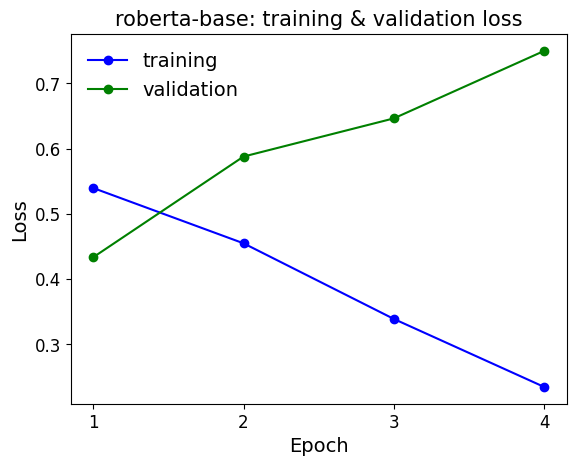

In [26]:
from matplotlib import pyplot

%matplotlib inline

pyplot.plot(df_stats['train_loss'], 'b-o', label="training")
pyplot.plot(df_stats['val_loss'], 'g-o', label="validation")
pyplot.title(f"{bert_model_name}: training & validation loss", fontsize=15)
pyplot.xlabel("Epoch", fontsize=14)
pyplot.ylabel("Loss", fontsize=14)
pyplot.legend(frameon=False, fontsize=14)
pyplot.xticks(df_stats.index.values.tolist(), fontsize=12)
pyplot.yticks(fontsize=12)
pyplot.savefig(f"{bert_model_name}/train_val_loss_plot.png")
pyplot.show()

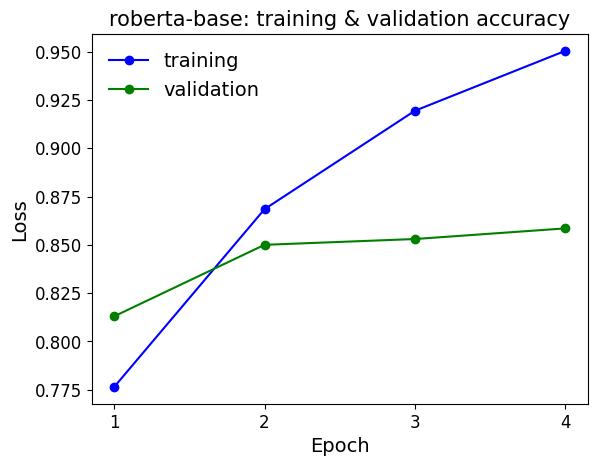

In [27]:
from matplotlib import pyplot

%matplotlib inline

pyplot.plot(df_stats['train_accuracy'], 'b-o', label="training")
pyplot.plot(df_stats['val_accuracy'], 'g-o', label="validation")
pyplot.title(f"{bert_model_name}: training & validation accuracy", fontsize=15)
pyplot.xlabel("Epoch", fontsize=14)
pyplot.ylabel("Loss", fontsize=14)
pyplot.legend(frameon=False, fontsize=14)
pyplot.xticks(df_stats.index.values.tolist(), fontsize=12)
pyplot.yticks(fontsize=12)
pyplot.savefig(f"{bert_model_name}/train_val_accuracy_plot.png")
pyplot.show()

## Performance on test set and prediction

In [28]:
print(type(y_test_known_labels))
test_tensor_known_labels = convert_to_dataset_torch(X_test_known_labels, y_test_known_labels)
test_dataloader = DataLoader(test_tensor_known_labels, 
                             sampler=SequentialSampler(test_tensor_known_labels), 
                             batch_size=batch_size)

#print(len(X_test_unknown_labels))
#features_tensor = torch.tensor(X_test_unknown_labels.to_numpy(), dtype=torch.float32)
#print(features_tensor.shape)

# Create dummy labels tensor

dummy_labels_series = pd.Series([-1] * len(X_test_unknown_labels))
# print(X_test_unknown_labels.shape)
test_tensor_unknown_labels = convert_to_dataset_torch(X_test_unknown_labels, dummy_labels_series)
predict_dataloader = DataLoader(test_tensor_unknown_labels, 
                             sampler=SequentialSampler(test_tensor_unknown_labels), 
                             batch_size=batch_size)

<class 'pandas.core.series.Series'>


100%|██████████| 4000/4000 [00:03<00:00, 1254.31it/s]


Shape of input_ids is torch.Size([4000, 512])
Shape of attention_masks is torch.Size([4000, 512])
Shape of labels is torch.Size([4000])


100%|██████████| 5000/5000 [00:04<00:00, 1242.14it/s]


Shape of input_ids is torch.Size([5000, 512])
Shape of attention_masks is torch.Size([5000, 512])
Shape of labels is torch.Size([5000])


## Evaluate on the test set with known labels
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set with known labels

In [29]:
bert_classification_model.eval()

total_val_loss, total_val_accuracy,\
predicted_logits_val, predicted_labels_val = val_batch(None, bert_classification_model, 
                                               test_dataloader, accuracy_score)

Validating epoch: None: 100%|██████████| 800/800 [01:13<00:00, 10.84batch/s]


## Making prediction on the test set with unknown labels

With the predict set prepared, we can apply our fine-tuned model to generate predictions on the test set with unknown labels

In [30]:
bert_classification_model.eval()

predicted_logits_test, predicted_labels_test = predict_batch(bert_classification_model, 
                                                   predict_dataloader)

Predicting: 100%|██████████| 1000/1000 [01:31<00:00, 10.93batch/s]


### We construct the testing result with corresponding truth labels and predicted labels by the fine-tuned BERT model. This testing data is part of the training data (train.tsv)

In [31]:
testing_results_known_labels = pd.DataFrame()
testing_results_known_labels["question1"] = X_test_known_labels["question1"]
testing_results_known_labels["question2"] = X_test_known_labels["question2"]
testing_results_known_labels["true_is_duplicate"] = y_test_known_labels
testing_results_known_labels["predicted_is_duplicate"] = predicted_labels_val
testing_results_known_labels.head()

,question1,question2,true_is_duplicate,predicted_is_duplicate
10650,"Where did ""European Jewish"" come from in my si...","I am doing my research on MRSA, but my results...",0,0
2041,Is there a way to get deleted Instagram pictur...,Can you delete someone's picture on Instagram?,0,0
8668,Why are the Åland Islands a part of Finland wh...,Why isn't Aland a part of Sweden?,1,0
1114,What do you feel is your purpose in life?,What according to YOU is the purpose of life?,1,1
13902,What's the difference between Vyvanse and Adde...,What is the difference between Adderall XR and...,1,1


### We construct the testing result with no known labels (the test.tsv file) with the predicted labels by the fine-tuned BERT model

In [32]:
testing_results_unknown_labels = pd.DataFrame()
testing_results_unknown_labels["question1"] = X_test_unknown_labels["question1"]
testing_results_unknown_labels["question2"] = X_test_unknown_labels["question2"]
testing_results_unknown_labels["predicted_is_duplicate"] = predicted_labels_test
testing_results_unknown_labels.head()

,question1,question2,predicted_is_duplicate
0,Would the idea of Trump and Putin in bed toget...,Do you think that if Donald Trump were elected...,0
1,What are the top ten Consumer-to-Consumer E-co...,What are the top ten Consumer-to-Business E-co...,1
2,Why don't people simply 'Google' instead of as...,Why do people ask Quora questions instead of j...,1
3,Is it safe to invest in social trade biz?,Is social trade geniune?,0
4,If the universe is expanding then does matter ...,If universe and space is expanding? Does that ...,1


### Saving testing results

In [33]:
testing_results_known_labels.to_csv(f"{bert_model_name}/testing_results_known_labels.csv", index=False)
testing_results_unknown_labels.to_csv(f"{bert_model_name}/testing_results_unknown_labels.csv", index=False)

In [34]:
!pip install data-science-utils

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


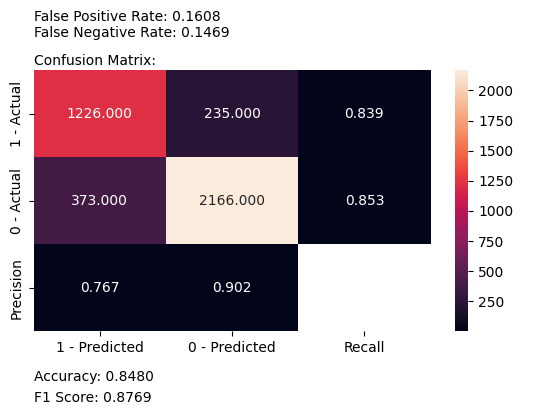

In [35]:
from ds_utils.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test_known_labels, predicted_labels_val, [1, 0])
pyplot.savefig(f"{bert_model_name}/confusion_matrix.png")
pyplot.show()

# Saving the fine-tuned model
First let's save our model with the method ``save_pretrained``, then save our tokenizer with ``save_pretrained``.

**Pay Attension**: tokenizer's ``save_pretrained`` need to get the path to save as a string.

In reality, it is not required to run this cell. Obtaining the results is already enough. The saved model would be extremely heavy, and there are already fine tuned BERT models on HuggingFace

In [36]:
from pathlib import Path

output_dir = Path("__file__").parents[0].absolute().joinpath(f"{bert_model_name}/model_save")
output_dir.mkdir(exist_ok=True)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`

# model_to_save = bert_classification_model.module if hasattr(bert_classification_model, 'module') else bert_classification_model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(str(output_dir.absolute()))